Code referenced from https://www.youtube.com/watch?v=CbTU92pbDKw

In [1]:
from bs4 import BeautifulSoup
import pandas as pd

# Load the HTML file
with open("Microsoft Corporation (MSFT) Stock Historical Prices & Data - Yahoo Finance.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")

# Find all rows in the table
rows = soup.find_all("tr", class_="yf-1jecxey")

# Parse each row
data = []
for row in rows:
    cells = row.find_all("td")
    if len(cells) == 7:
        data.append([
            cells[0].text.strip(),  # Date
            float(cells[1].text.strip()),  # Open
            float(cells[2].text.strip()),  # High
            float(cells[3].text.strip()),  # Low
            float(cells[4].text.strip()),  # Close
            float(cells[5].text.strip()),  # Adj Close
            int(cells[6].text.strip().replace(",", ""))  # Volume
        ])

# Convert to DataFrame
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = pd.DataFrame(data, columns=columns)

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date
df = df.sort_values(by='Date')

# Display the DataFrame
print(df)


           Date    Open    High     Low   Close  Adj Close      Volume
9926 1986-03-13    0.09    0.10    0.09    0.10       0.06  1031788800
9925 1986-03-14    0.10    0.10    0.10    0.10       0.06   308160000
9924 1986-03-17    0.10    0.10    0.10    0.10       0.06   133171200
9923 1986-03-18    0.10    0.10    0.10    0.10       0.06    67766400
9922 1986-03-19    0.10    0.10    0.10    0.10       0.06    47894400
...         ...     ...     ...     ...     ...        ...         ...
4    2025-07-31  555.23  555.45  531.90  533.50     533.50    51617300
3    2025-08-01  535.00  535.80  520.86  524.11     524.11    28977600
2    2025-08-04  528.27  538.25  528.13  535.64     535.64    25349000
1    2025-08-05  537.18  537.30  527.24  527.75     527.75    19144000
0    2025-08-06  530.82  531.70  524.59  526.16     526.16     9689806

[9927 rows x 7 columns]


In [2]:
df = df[['Date', 'Close']]

In [3]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.10
1986-03-14,0.10
1986-03-17,0.10
1986-03-18,0.10
1986-03-19,0.10
...,...
2025-07-31,533.50
2025-08-01,524.11
2025-08-04,535.64


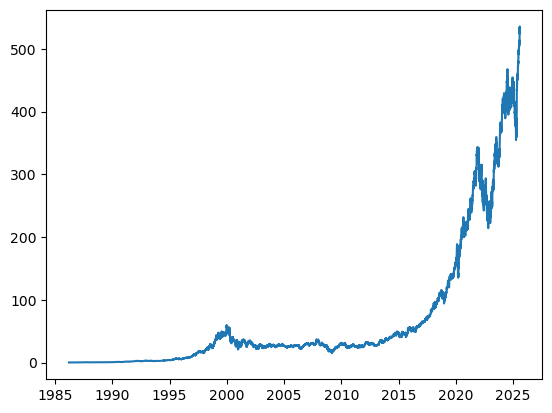

In [4]:
import matplotlib.pyplot as plt
plt.plot(df)

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [6]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

# target 1-3 are previous n values. This converts the inputs to the target output.

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.99,237.58,235.46,232.34
1,2021-03-26,237.58,235.46,232.34,236.48
2,2021-03-29,235.46,232.34,236.48,235.24
3,2021-03-30,232.34,236.48,235.24,231.85
4,2021-03-31,236.48,235.24,231.85,235.77
...,...,...,...,...,...
247,2022-03-17,276.44,287.15,294.39,295.22
248,2022-03-18,287.15,294.39,295.22,300.43
249,2022-03-21,294.39,295.22,300.43,299.16
250,2022-03-22,295.22,300.43,299.16,304.06


In [7]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:,0]

  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # reshape data for the tf model last value represents univariate forecasting

  Y = df_as_np[:,-1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

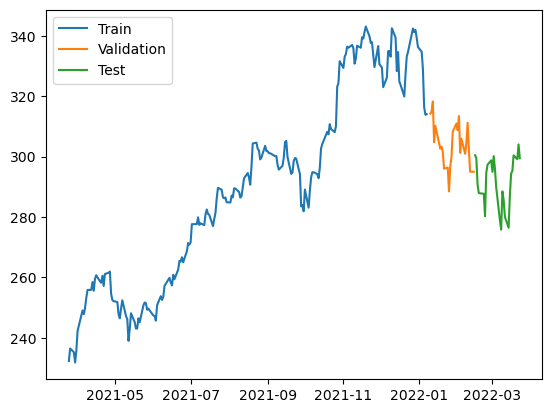

In [8]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # 3 days in the past
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 84884.3594 - mean_absolute_error: 289.6674 - val_loss: 92153.0078 - val_mean_absolute_error: 303.4799
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 83680.9922 - mean_absolute_error: 287.6497 - val_loss: 91749.6172 - val_mean_absolute_error: 302.8145
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83917.5547 - mean_absolute_error: 287.9157 - val_loss: 91342.2969 - val_mean_absolute_error: 302.1412
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 81934.6641 - mean_absolute_error: 284.4799 - val_loss: 90831.9531 - val_mean_absolute_error: 301.2955
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 82049.3672 - mean_absolute_error: 284.7471 - val_loss: 90139.8828 - val_mean_absolute_error: 300.1447
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 82637.0469 - mean_absolute_error: 285.7359 - val_loss: 89120.8594 - val_mean_absolute_error: 298.4424
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


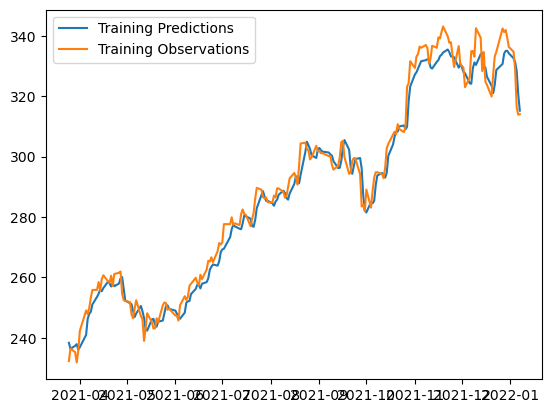

In [10]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


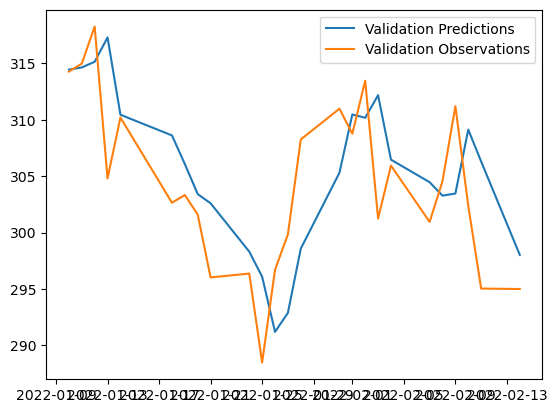

In [11]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


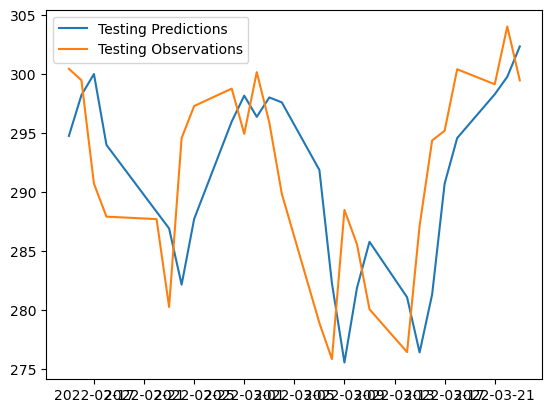

In [12]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

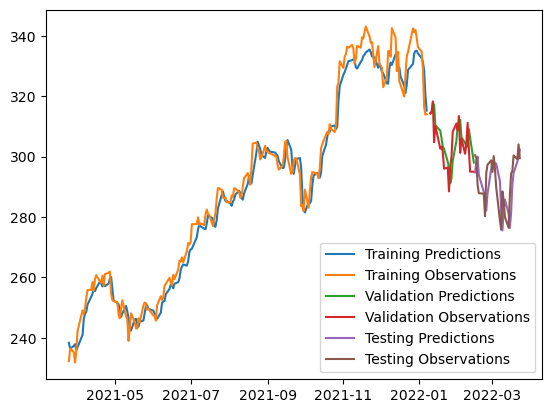

In [13]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])